=== UNIFIED SALES FORECASTING PIPELINE ===
Loaded 8,000 rows | Dates: 2020-01-01 → 2023-12-31
Monthly periods: 48 | Avg monthly sales: $9,633,617.71
Feature rows after dropna: 36 (dropped 12)

Time splits:
  Train: 25 | 2021-01-31 → 2023-01-31
  Val:   5 | 2023-02-28 → 2023-06-30
  Test:  6 | 2023-07-31 → 2023-12-31

=== MODEL TRAINING & COMPARISON ===

[LinearRegression]  Val RMSE=$325,332.76  |  Test RMSE=$295,800.74  |  Test R²=0.809

[Ridge]  Val RMSE=$311,633.66  |  Test RMSE=$241,812.06  |  Test R²=0.872

[Lasso]  Val RMSE=$1,856,097.22  |  Test RMSE=$971,181.92  |  Test R²=-1.060

[RandomForest]  Val RMSE=$911,141.01  |  Test RMSE=$535,800.85  |  Test R²=0.373

=== BEST (by Val RMSE): Ridge  (Val RMSE=$311,633.66) ===

Top 10 features (|coef|):
          feature  coefficient
 revenue_per_unit     0.032074
      sales_diff1     0.021749
     sales_diff12     0.019928
     quantity_sum     0.015791
  quantity_growth     0.013527
customers_x_price     0.011955
      sales_lag12    

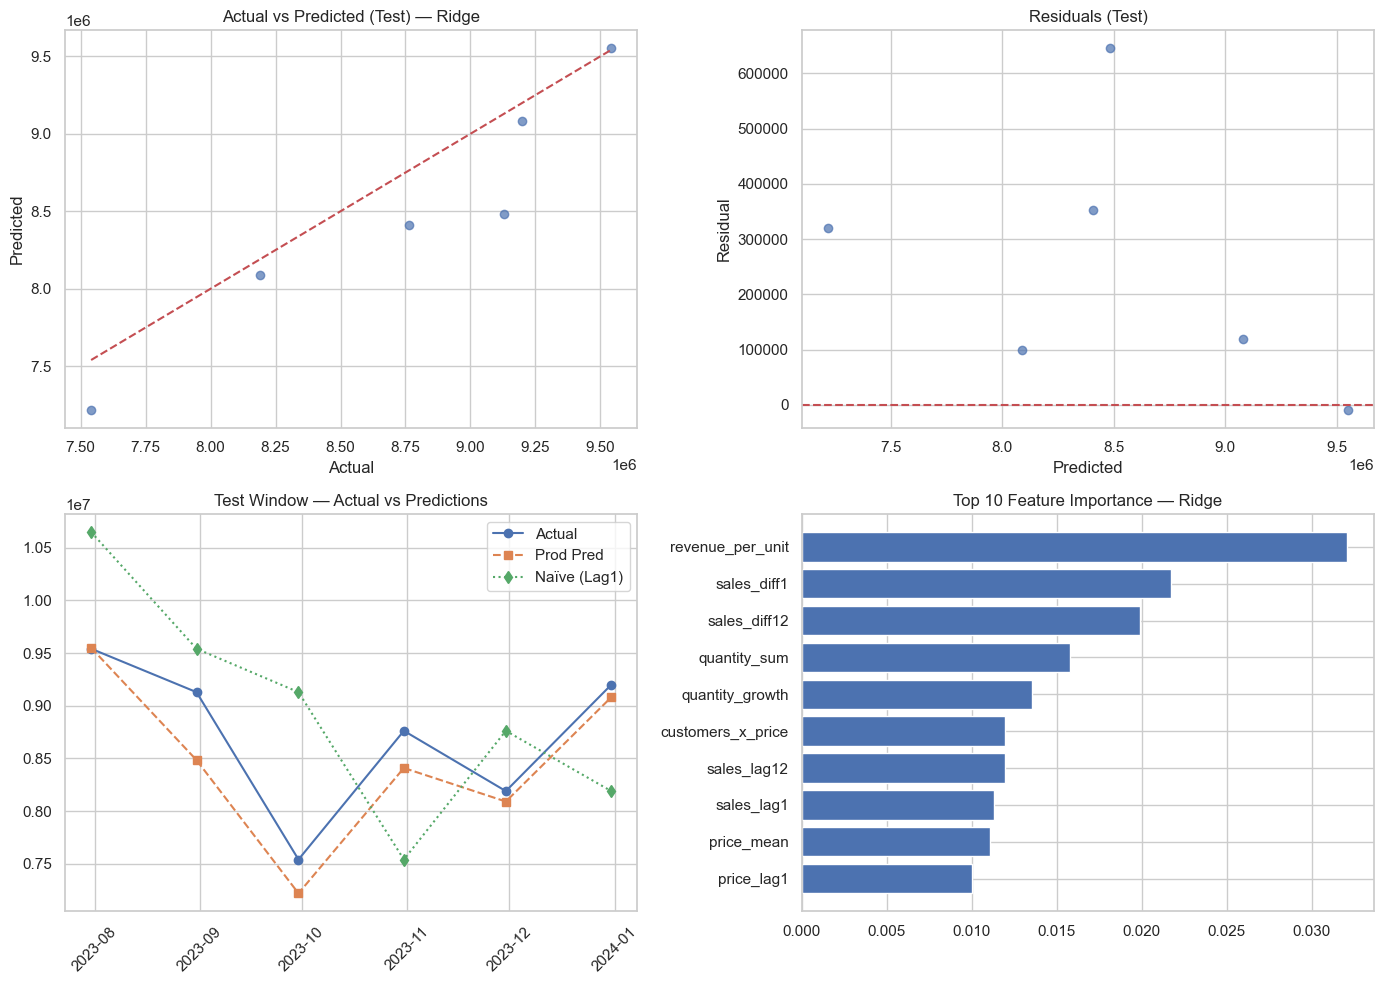


Saved best production model → ..\models\best_forecast_model_Ridge_prod.joblib
Saved historical predictions → ..\data\forecasts\historical_predictions_unified.csv
Saved model comparison → ..\data\forecasts\model_comparison_unified.csv

Saved future forecasts → ..\data\forecasts\future_forecasts_unified.csv

Next 6 periods forecast:
                forecast  forecast_log
date                                  
2024-01-31  8.598067e+06     15.967048
2024-02-29  8.456314e+06     15.950424
2024-03-31  8.452679e+06     15.949994
2024-04-30  8.654341e+06     15.973572
2024-05-31  8.493667e+06     15.954831
2024-06-30  8.512610e+06     15.957059


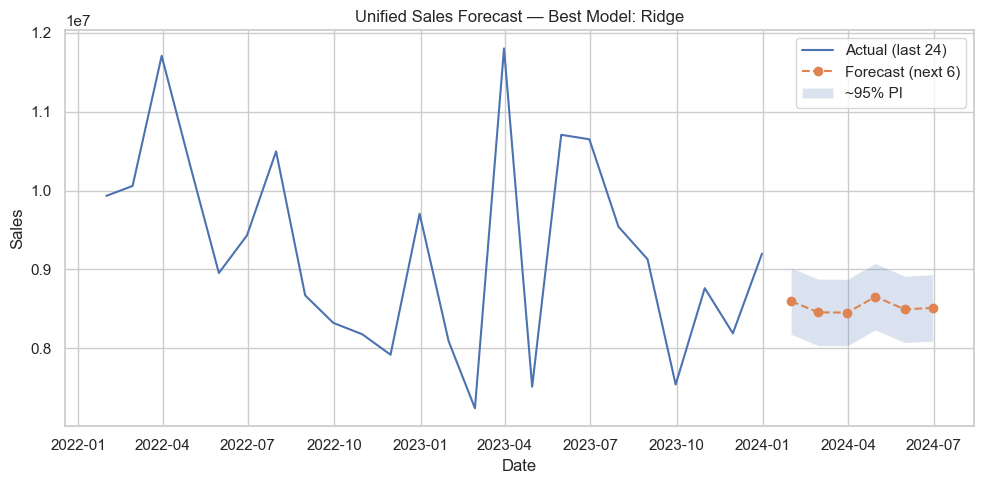


=== PIPELINE COMPLETE ===


In [7]:
# ===============================================================
# Unified Sales Forecasting Pipeline (Research → Production)
# - Monthly aggregation with target + exogenous features
# - Rich feature engineering (lags, MAs, seasonality, trend, etc.)
# - Model zoo: Linear, Ridge, Lasso, RandomForest (time-aware split)
# - Metrics on Train/Val/Test (MAE, RMSE, R2, MAPE, sMAPE)
# - Best model selection by Val RMSE + feature importance
# - Production refit (Train+Val), Naïve baseline, leakage sanity checks
# - Leak-safe recursive 6-step forecast with robust exogenous fillers
# - Saves models, predictions, comparisons, and future forecasts
# ===============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

sns.set(style="whitegrid")
print("=== UNIFIED SALES FORECASTING PIPELINE ===")

# ---------------------------------------------------------------
# 0) Paths & I/O
# ---------------------------------------------------------------
PATH_IN = "../data/processed/cleaned_transactions.csv"
DIR_MODELS = Path("../models")
DIR_FORECASTS = Path("../data/forecasts")
DIR_PROCESSED = Path("../data/processed")

DIR_MODELS.mkdir(parents=True, exist_ok=True)
DIR_FORECASTS.mkdir(parents=True, exist_ok=True)
DIR_PROCESSED.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------
# 1) Load & monthly aggregation (target + exogenous)
# ---------------------------------------------------------------
df = pd.read_csv(PATH_IN)
if "sale_date" not in df.columns or "total_value" not in df.columns:
    raise ValueError("Input must include 'sale_date' and 'total_value' columns.")

df["sale_date"] = pd.to_datetime(df["sale_date"], errors="coerce")
df = df.dropna(subset=["sale_date"]).copy()

print(f"Loaded {df.shape[0]:,} rows | Dates: {df['sale_date'].min().date()} → {df['sale_date'].max().date()}")

# Aggregate monthly with optional exogenous fields if present
monthly = df.groupby(pd.Grouper(key="sale_date", freq="ME")).agg({
    "total_value": "sum",                                  # target (sales)
    **({"quantity": ["sum", "mean", "std"]} if "quantity" in df.columns else {}),
    **({"price": ["mean", "std"]} if "price" in df.columns else {}),
    **({"customer_id": "nunique"} if "customer_id" in df.columns else {}),
    **({"product_id": "nunique"} if "product_id" in df.columns else {}),
    **({"age": ["mean", "std"]} if "age" in df.columns else {}),
}).round(4)

# Flatten MultiIndex columns
def _flatten_cols(cols):
    out = []
    for c in cols:
        if isinstance(c, tuple):
            base = "_".join([str(x) for x in c if x])
            out.append(base)
        else:
            out.append(c)
    return out

monthly.columns = _flatten_cols(monthly.columns)
monthly = monthly.rename(columns={"total_value_sum": "sales",
                                  "total_value": "sales"})  # in case no multiindex

# Ensure continuous monthly index
full_idx = pd.date_range(monthly.index.min(), monthly.index.max(), freq="ME")
monthly = monthly.reindex(full_idx).sort_index()
monthly.index.name = "date"

# Fill target & exogenous gaps (reasonable defaults)
monthly["sales"] = monthly["sales"].fillna(0.0)
for col in monthly.columns:
    if col == "sales":
        continue
    monthly[col] = monthly[col].fillna(method="ffill").fillna(0.0)

print(f"Monthly periods: {len(monthly)} | Avg monthly sales: ${monthly['sales'].mean():,.2f}")

# ---------------------------------------------------------------
# 2) Feature engineering (rich, leak-safe)
# ---------------------------------------------------------------
def engineer_features(data, target_col="sales", use_target_lags=True):
    df_ = data.copy()
    # Target in log space
    df_["sales_log"] = np.log1p(df_[target_col])

    # Time features
    df_["month"] = df_.index.month
    df_["quarter"] = df_.index.quarter
    df_["year"] = df_.index.year
    df_["month_sin"] = np.sin(2 * np.pi * df_["month"] / 12)
    df_["month_cos"] = np.cos(2 * np.pi * df_["month"] / 12)
    df_["quarter_sin"] = np.sin(2 * np.pi * df_["quarter"] / 4)
    df_["quarter_cos"] = np.cos(2 * np.pi * df_["quarter"] / 4)
    df_["trend"] = np.arange(1, len(df_) + 1)
    df_["trend_squared"] = df_["trend"] ** 2

    # Target lags / MAs / diffs / volatility (properly shifted)
    if use_target_lags:
        for lag in [1, 2, 3, 6, 12]:
            df_[f"sales_lag{lag}"] = df_["sales_log"].shift(lag)

        df_["sales_ma3"] = df_["sales_log"].shift(1).rolling(3, min_periods=1).mean()
        df_["sales_ma6"] = df_["sales_log"].shift(1).rolling(6, min_periods=1).mean()
        df_["sales_ma12"] = df_["sales_log"].shift(1).rolling(12, min_periods=1).mean()
        df_["sales_ewm"] = df_["sales_log"].shift(1).ewm(span=3, adjust=False).mean()

        df_["sales_diff1"] = df_["sales_log"].diff(1)
        df_["sales_diff12"] = df_["sales_log"].diff(12)
        df_["sales_volatility"] = df_["sales_log"].shift(1).rolling(6, min_periods=1).std()

    # Exogenous features if available
    if "customer_id_nunique" in df_.columns:
        df_["customers_lag1"] = df_["customer_id_nunique"].shift(1)
        df_["customers_lag3"] = df_["customer_id_nunique"].shift(3)
        df_["customers_ma3"] = df_["customer_id_nunique"].rolling(3, min_periods=1).mean()
        df_["customer_growth"] = df_["customer_id_nunique"].pct_change()

    if "quantity_sum" in df_.columns:
        df_["quantity_lag1"] = df_["quantity_sum"].shift(1)
        df_["quantity_ma3"] = df_["quantity_sum"].rolling(3, min_periods=1).mean()
        df_["quantity_growth"] = df_["quantity_sum"].pct_change()

    if "price_mean" in df_.columns:
        df_["price_lag1"] = df_["price_mean"].shift(1)
        df_["price_change"] = df_["price_mean"].pct_change()

    # Interactions / convenience
    if "customer_id_nunique" in df_.columns and "price_mean" in df_.columns:
        df_["customers_x_price"] = df_["customer_id_nunique"] * df_["price_mean"]
    if "quantity_sum" in df_.columns and "price_mean" in df_.columns:
        df_["revenue_per_unit"] = df_[target_col] / (df_["quantity_sum"] + 1)

    # Holiday flags (examples; adapt to business calendar if needed)
    df_["is_december"] = (df_["month"] == 12).astype(int)
    df_["is_january"] = (df_["month"] == 1).astype(int)

    return df_

data_feat = engineer_features(monthly, use_target_lags=True)

# Drop rows introduced by lags/MAs
initial_len = len(data_feat)
data_clean = data_feat.dropna()
print(f"Feature rows after dropna: {len(data_clean)} (dropped {initial_len - len(data_feat.dropna())})")

# ---------------------------------------------------------------
# 3) Define splits (Train/Val/Test)
# ---------------------------------------------------------------
n = len(data_clean)
train_size = int(n * 0.7)
val_size = int(n * 0.15)
train_data = data_clean.iloc[:train_size]
val_data = data_clean.iloc[train_size:train_size + val_size]
test_data = data_clean.iloc[train_size + val_size:]

print("\nTime splits:")
print(f"  Train: {len(train_data)} | {train_data.index[0].date()} → {train_data.index[-1].date()}")
print(f"  Val:   {len(val_data)} | {val_data.index[0].date()} → {val_data.index[-1].date()}")
print(f"  Test:  {len(test_data)} | {test_data.index[0].date()} → {test_data.index[-1].date()}")

# Feature sets
target_col = "sales_log"
cat_features = ["month", "quarter"]
num_features = [c for c in data_clean.columns
                if c not in [target_col, "sales", "year"] + cat_features]

X_train = train_data[cat_features + num_features]
X_val   = val_data[cat_features + num_features]
X_test  = test_data[cat_features + num_features]
y_train = train_data[target_col]
y_val   = val_data[target_col]
y_test  = test_data[target_col]

# ---------------------------------------------------------------
# 4) Preprocessing & models
# ---------------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
        ("num", StandardScaler(), num_features)
    ],
    remainder="drop"
)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
}

# ---------------------------------------------------------------
# 5) Training & evaluation
# ---------------------------------------------------------------
def _metrics_from_log(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    mask = y_true != 0
    mape = (np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100) if mask.sum() > 0 else np.inf
    smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape, "SMAPE": smape}

results = {}
best_model_name = None
best_val_rmse = float("inf")

print("\n=== MODEL TRAINING & COMPARISON ===")
for name, mdl in models.items():
    pipe = Pipeline([("pre", preprocessor), ("model", mdl)])
    pipe.fit(X_train, y_train)

    yhat_tr = pipe.predict(X_train)
    yhat_va = pipe.predict(X_val)
    yhat_te = pipe.predict(X_test)

    m_tr = _metrics_from_log(y_train, yhat_tr)
    m_va = _metrics_from_log(y_val, yhat_va)
    m_te = _metrics_from_log(y_test, yhat_te)

    results[name] = {"pipeline": pipe, "train": m_tr, "val": m_va, "test": m_te,
                     "pred": {"train": yhat_tr, "val": yhat_va, "test": yhat_te}}
    print(f"\n[{name}]  Val RMSE=${m_va['RMSE']:,.2f}  |  Test RMSE=${m_te['RMSE']:,.2f}  |  Test R²={m_te['R2']:.3f}")

    if m_va["RMSE"] < best_val_rmse:
        best_val_rmse = m_va["RMSE"]
        best_model_name = name

print(f"\n=== BEST (by Val RMSE): {best_model_name}  (Val RMSE=${best_val_rmse:,.2f}) ===")
best_val_pipeline = results[best_model_name]["pipeline"]

# ---------------------------------------------------------------
# 6) Feature importance for the best validation model
# ---------------------------------------------------------------
def extract_feature_names(pipeline, cat_feats, num_feats):
    ohe = pipeline.named_steps["pre"].named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(cat_feats))
    return cat_names + num_feats

importance_df = pd.DataFrame()
if best_model_name in ["LinearRegression", "Ridge", "Lasso"]:
    feature_names = extract_feature_names(best_val_pipeline, cat_features, num_features)
    coefs = best_val_pipeline.named_steps["model"].coef_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefs,
        "abs_coefficient": np.abs(coefs)
    }).sort_values("abs_coefficient", ascending=False)
    print("\nTop 10 features (|coef|):")
    print(importance_df.head(10)[["feature", "coefficient"]].to_string(index=False))
elif best_model_name == "RandomForest":
    feature_names = extract_feature_names(best_val_pipeline, cat_features, num_features)
    imps = best_val_pipeline.named_steps["model"].feature_importances_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": imps
    }).sort_values("importance", ascending=False)
    print("\nTop 10 features (RF importance):")
    print(importance_df.head(10).to_string(index=False))

# ---------------------------------------------------------------
# 7) Production refit (Train+Val), test eval, & baseline
# ---------------------------------------------------------------
trainval_data = data_clean.iloc[:train_size + val_size]
X_trv = trainval_data[cat_features + num_features]
y_trv = trainval_data[target_col]

prod_pipeline = Pipeline([("pre", preprocessor), ("model", models[best_model_name])])
prod_pipeline.fit(X_trv, y_trv)

# Evaluate on untouched test with prod model
yhat_test_prod = prod_pipeline.predict(X_test)
test_metrics = _metrics_from_log(y_test, yhat_test_prod)

# Naïve baseline: last-observation (Lag1 in original space)
naive_test = np.expm1(test_data["sales_lag1"].values)
true_test = np.expm1(y_test.values)

def _summarize(y_true, y_pred, label):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2   = r2_score(y_true, y_pred)
    denom = np.where(y_true == 0, 1, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100
    smp  = np.mean(2*np.abs(y_true - y_pred)/(np.abs(y_true)+np.abs(y_pred)+1e-8))*100
    print(f"[{label}]  MAE=${mae:,.2f}  RMSE=${rmse:,.2f}  R²={r2:.3f}  MAPE={mape:.2f}%  sMAPE={smp:.2f}%")
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape, "SMAPE": smp}

print("\n=== PRODUCTION MODEL (Train+Val fit) — TEST EVALUATION ===")
m_prod_test = _summarize(true_test, np.expm1(yhat_test_prod), f"{best_model_name} (Prod)")
m_naive = _summarize(true_test, naive_test, "Naïve (Lag1)")

# Leakage sanity checks
print("\n=== LEAKAGE CHECKS ===")
print(f"R²(Test) < 0.95: {'✅ PASS' if m_prod_test['R2'] < 0.95 else '⚠️ High — verify no leakage'}")
print(f"RMSE(Test) > 0:  {'✅ PASS' if m_prod_test['RMSE'] > 0 else '❌ Suspiciously perfect'}")
if not importance_df.empty:
    max_coef = (importance_df["abs_coefficient"].max()
                if "abs_coefficient" in importance_df.columns
                else importance_df["importance"].max())
    print(f"Coefficients/Importances reasonable: {'✅ PASS' if max_coef < 1e3 else '⚠️ Check extremes'}")

# ---------------------------------------------------------------
# 8) Visuals (compact)
# ---------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0,0].scatter(true_test, np.expm1(yhat_test_prod), alpha=0.7)
lim0, lim1 = true_test.min(), true_test.max()
axes[0,0].plot([lim0, lim1], [lim0, lim1], "r--")
axes[0,0].set_title(f"Actual vs Predicted (Test) — {best_model_name}")
axes[0,0].set_xlabel("Actual"); axes[0,0].set_ylabel("Predicted")

resid = true_test - np.expm1(yhat_test_prod)
axes[0,1].scatter(np.expm1(yhat_test_prod), resid, alpha=0.7)
axes[0,1].axhline(0, color="r", linestyle="--")
axes[0,1].set_title("Residuals (Test)")
axes[0,1].set_xlabel("Predicted"); axes[0,1].set_ylabel("Residual")

axes[1,0].plot(test_data.index, true_test, "o-", label="Actual")
axes[1,0].plot(test_data.index, np.expm1(yhat_test_prod), "s--", label="Prod Pred")
axes[1,0].plot(test_data.index, naive_test, "d:", label="Naïve (Lag1)")
axes[1,0].legend(); axes[1,0].set_title("Test Window — Actual vs Predictions")
axes[1,0].tick_params(axis="x", rotation=45)

# Feature importance chart if available
if not importance_df.empty:
    top = importance_df.copy()
    if "abs_coefficient" in top.columns:
        top = top.sort_values("abs_coefficient", ascending=False).head(10)
        vals = top["abs_coefficient"].values
    else:
        top = top.sort_values("importance", ascending=False).head(10)
        vals = top["importance"].values
    axes[1,1].barh(top["feature"][::-1], vals[::-1])
    axes[1,1].set_title(f"Top 10 Feature Importance — {best_model_name}")
else:
    axes[1,1].axis("off")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# 9) Save artifacts
# ---------------------------------------------------------------
best_model_path = DIR_MODELS / f"best_forecast_model_{best_model_name}_prod.joblib"
joblib.dump(prod_pipeline, best_model_path)
print(f"\nSaved best production model → {best_model_path}")

# Build historical predictions frame indexed by date
hist_pred = pd.DataFrame({
    "date": data_clean.index,
    "actual": np.expm1(data_clean[target_col]).values
}).set_index("date")

# Tag splits
hist_pred["split"] = "train"
hist_pred.loc[val_data.index,  "split"] = "val"
hist_pred.loc[test_data.index, "split"] = "test"

# Attach predictions from the best validation pipeline (aligned by index)
hist_pred.loc[train_data.index, "predicted_valbest"] = np.expm1(results[best_model_name]["pred"]["train"])
hist_pred.loc[val_data.index,   "predicted_valbest"] = np.expm1(results[best_model_name]["pred"]["val"])
hist_pred.loc[test_data.index,  "predicted_valbest"] = np.expm1(results[best_model_name]["pred"]["test"])

# Attach predictions from the production refit (test only)
hist_pred.loc[test_data.index, "predicted_prod"] = np.expm1(yhat_test_prod)

# Save (reset index to keep a 'date' column)
hist_pred.reset_index().to_csv(DIR_FORECASTS / "historical_predictions_unified.csv", index=False)
print(f"Saved historical predictions → {DIR_FORECASTS / 'historical_predictions_unified.csv'}")

comp_df = pd.DataFrame({
    m: {
        "Train_RMSE": results[m]["train"]["RMSE"],
        "Val_RMSE":   results[m]["val"]["RMSE"],
        "Test_RMSE":  results[m]["test"]["RMSE"],
        "Test_R2":    results[m]["test"]["R2"],
        "Test_MAPE":  results[m]["test"]["MAPE"]
    } for m in results
}).T.sort_values("Val_RMSE")
comp_path = DIR_FORECASTS / "model_comparison_unified.csv"
comp_df.to_csv(comp_path)
print(f"Saved model comparison → {comp_path}")

# ---------------------------------------------------------------
# 10) Recursive forecast (6 steps) using production model
# ---------------------------------------------------------------
def _safe_fill_future_exog(history_df, cols, k_recent=3):
    vals = {}
    for c in cols:
        if c not in history_df.columns: 
            vals[c] = 0.0
            continue
        tail = history_df[c].tail(k_recent).dropna()
        if len(tail) > 0:
            vals[c] = float(tail.mean())
        else:
            last = history_df[c].tail(1)
            vals[c] = float(last.iloc[0]) if len(last) else 0.0
    return vals

def recursive_forecast_prod(pipeline, last_df, cat_feats, num_feats, periods=6):
    """
    Leak-safe recursive forecast on log target.
    - Feeds back predicted sales_log into lag/MAs via engineered features already present in last_df.
    - For exogenous features, uses recent means/trends via _safe_fill_future_exog().
    """
    forecasts = []
    current = last_df.copy()

    for h in range(periods):
        next_date = current.index[-1] + pd.tseries.frequencies.to_offset("ME")
        next_row = pd.DataFrame(index=[next_date])

        # time features
        next_row["month"] = next_date.month
        next_row["quarter"] = (next_date.month - 1) // 3 + 1
        next_row["month_sin"] = np.sin(2 * np.pi * next_row["month"] / 12)
        next_row["month_cos"] = np.cos(2 * np.pi * next_row["month"] / 12)
        next_row["quarter_sin"] = np.sin(2 * np.pi * next_row["quarter"] / 4)
        next_row["quarter_cos"] = np.cos(2 * np.pi * next_row["quarter"] / 4)
        next_row["trend"] = current["trend"].iloc[-1] + 1
        next_row["trend_squared"] = next_row["trend"] ** 2
        next_row["is_december"] = int(next_row["month"].iloc[0] == 12)
        next_row["is_january"] = int(next_row["month"].iloc[0] == 1)

        # target lags & MAs from current sales_log
        if "sales_log" in current.columns:
            for lag in [1, 2, 3, 6, 12]:
                col = f"sales_lag{lag}"
                if lag <= len(current):
                    next_row[col] = current["sales_log"].iloc[-lag]
                else:
                    next_row[col] = current["sales_log"].mean()
            next_row["sales_ma3"] = current["sales_log"].tail(3).mean()
            next_row["sales_ma6"] = current["sales_log"].tail(6).mean()
            next_row["sales_ma12"] = current["sales_log"].tail(12).mean()
            next_row["sales_ewm"] = current["sales_log"].ewm(span=3, adjust=False).mean().iloc[-1]
            # diffs & volatility
            next_row["sales_diff1"] = current["sales_log"].iloc[-1] - current["sales_log"].iloc[-2] if len(current) >= 2 else 0.0
            next_row["sales_diff12"] = current["sales_log"].iloc[-1] - current["sales_log"].iloc[-12] if len(current) >= 12 else 0.0
            next_row["sales_volatility"] = current["sales_log"].tail(6).std()

        # exogenous (simple recent mean/trend fillers)
        exog_cols = [c for c in ["customer_id_nunique", "quantity_sum", "price_mean",
                                 "customers_lag1","customers_lag3","customers_ma3","customer_growth",
                                 "quantity_lag1","quantity_ma3","quantity_growth",
                                 "price_lag1","price_change",
                                 "customers_x_price","revenue_per_unit"]
                     if c in current.columns]
        exog_vals = _safe_fill_future_exog(current, exog_cols, k_recent=3)
        next_row = pd.concat([next_row, pd.DataFrame([exog_vals], index=[next_date])], axis=1)

        # Fill missing required features
        needed = cat_feats + num_feats
        for col in needed:
            if col not in next_row.columns:
                if col in current.columns:
                    next_row[col] = current[col].tail(3).mean()
                else:
                    next_row[col] = 0.0

        # Predict next log-sales
        X_next = next_row[cat_feats + num_feats]
        y_next_log = pipeline.predict(X_next)[0]
        y_next = float(np.expm1(y_next_log))
        forecasts.append((next_date, y_next, float(y_next_log)))

        # append to current with the freshly predicted log target
        next_row["sales_log"] = y_next_log
        next_row["sales"] = y_next
        current = pd.concat([current, next_row], axis=0)

    fcst = pd.DataFrame(forecasts, columns=["date", "forecast", "forecast_log"]).set_index("date")
    return fcst

# Build minimal history containing engineered features (we already have them in data_clean)
# Use all available data for recursion starting point (production-like)
future_fcst = recursive_forecast_prod(prod_pipeline, data_clean, cat_features, num_features, periods=6)
future_path = DIR_FORECASTS / "future_forecasts_unified.csv"
future_fcst.to_csv(future_path)
print(f"\nSaved future forecasts → {future_path}")
print("\nNext 6 periods forecast:")
print(future_fcst)

# Confidence bands using test residual std (simple heuristic)
resid_std = resid.std() if len(resid) else 0.0
fc_lo = np.maximum(future_fcst["forecast"] - 1.96 * resid_std, 0.0)
fc_hi = future_fcst["forecast"] + 1.96 * resid_std

plt.figure(figsize=(10,5))
plt.plot(data_clean.index[-24:], np.expm1(data_clean[target_col]).iloc[-24:], label="Actual (last 24)")
plt.plot(future_fcst.index, future_fcst["forecast"], "o--", label="Forecast (next 6)")
plt.fill_between(future_fcst.index, fc_lo, fc_hi, alpha=0.2, label="~95% PI")
plt.title(f"Unified Sales Forecast — Best Model: {best_model_name}")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.tight_layout(); plt.show()

print("\n=== PIPELINE COMPLETE ===")
